We recently added object cuts (the ones called `ljsource_cuts`) so that our object collections match those used for lepton-jet clustering. These cuts will modify every result that relies on PF electrons, PF photons, PF muons, and DSA muons, so I thought it would be good to create a single notebook that summarizes the effects of these cuts.

In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()

Run selections with and without ljsource cuts. Don't place any cuts on the LJs themselves.

In [2]:
samples = [
    "2Mu2E_200GeV_1p2GeV_24mm",
]
fileset = utilities.make_fileset(samples, "ffntuple_v4")

runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
    #maxchunks=1,
)

channels = [
    "pvAndCosmic_cuts",
    "baseNoLj",
]
p = sidm_processor.SidmProcessor(
    channels,
    ["base_plus_gen"]
)

output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
hists = output["out"][samples[0]]["hists"]

Output()

Output()

First take a look at basic lepton and photon distributions with and w/o ljsource cuts. 

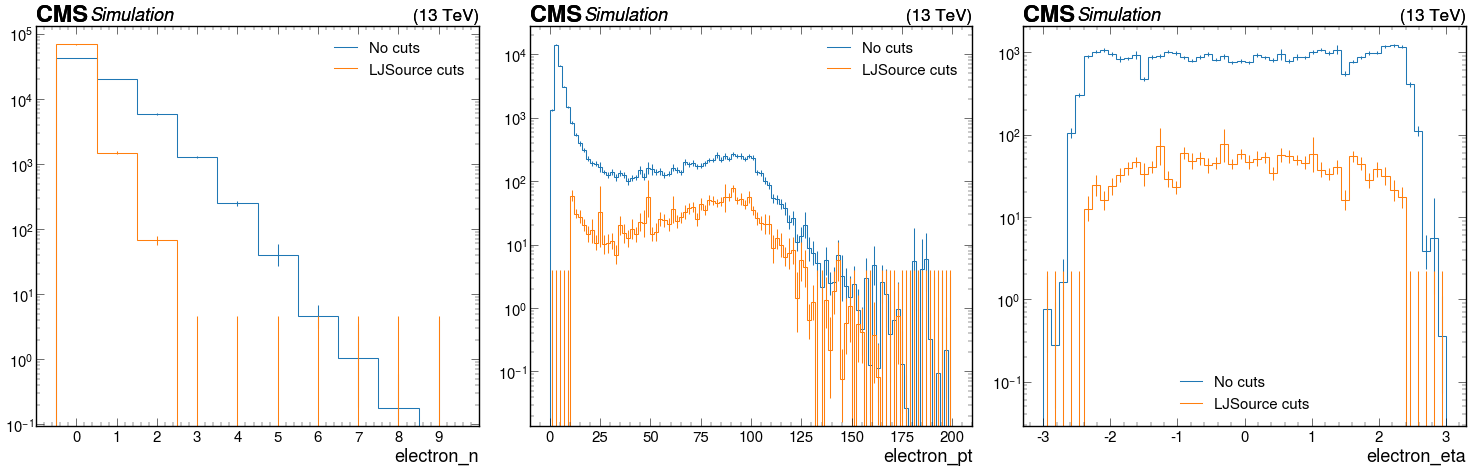

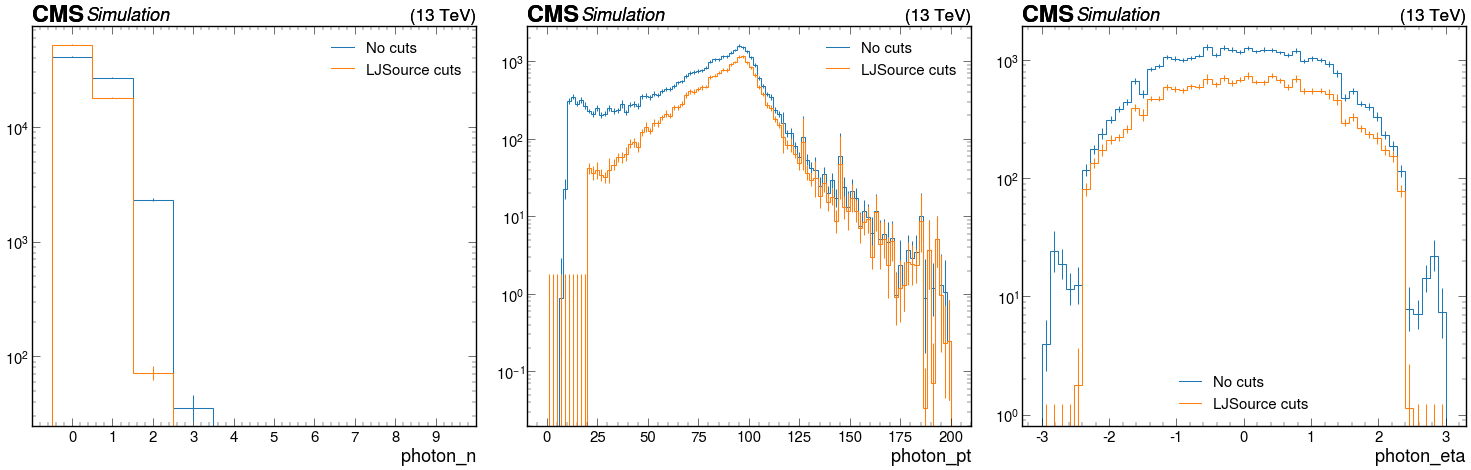

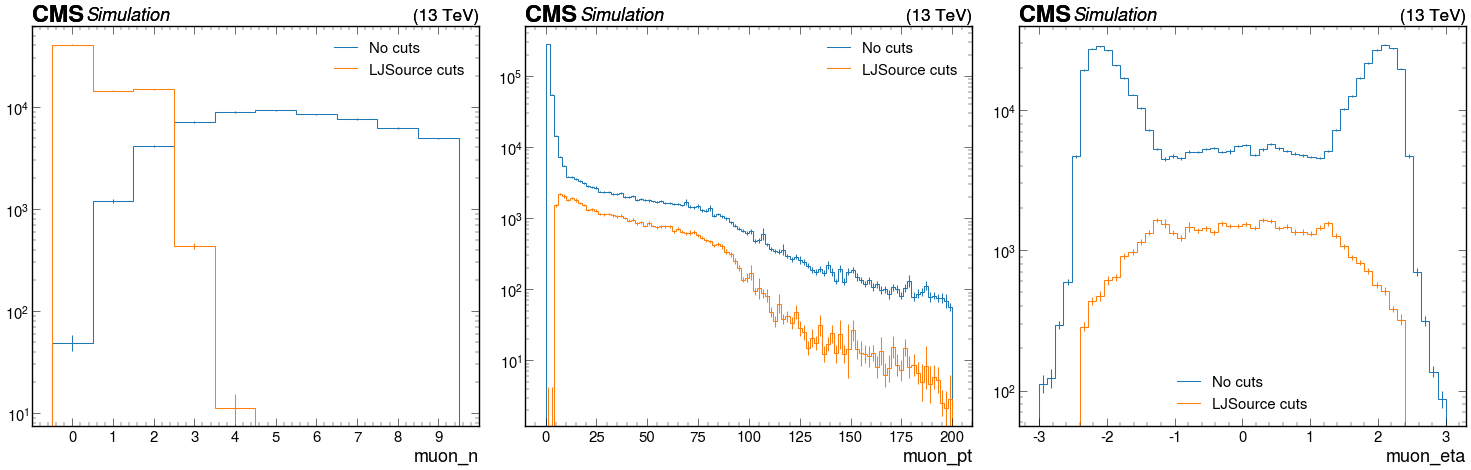

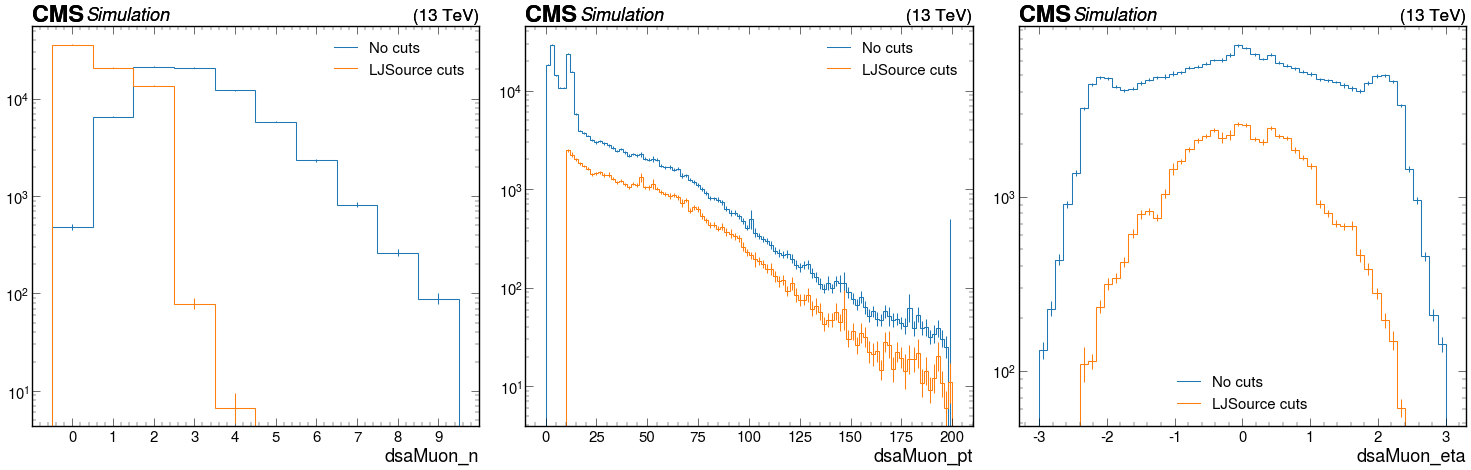

In [3]:
legend = ["No cuts", "LJSource cuts"]
def plot_number_pt_eta(obj, add_d0=False):
    plt.subplots(1, 3, figsize=(30, 10))
    plt.subplot(1, 3, 1)
    for ch in channels:
        utilities.plot(hists[f"{obj}_n"][ch, :])
    plt.yscale("log")
    plt.legend(legend)
    plt.subplot(1, 3, 2)
    for ch in channels:
        utilities.plot(hists[f"{obj}_pt"][ch, :])
    plt.yscale("log")
    plt.legend(legend)
    plt.subplot(1, 3, 3)
    for ch in channels:
        utilities.plot(hists[f"{obj}_eta_phi"][ch, :, :].project(f"{obj}_eta"))
    plt.yscale("log")
    plt.legend(legend)
    plt.tight_layout()

plot_number_pt_eta("electron")
plot_number_pt_eta("photon")
plot_number_pt_eta("muon")
plot_number_pt_eta("dsaMuon")

Next, take a look at effect of ljsource cuts on the dR between gen electrons and muons (all of which come from dark photon decays in this sample) and reco electrons, muons, and photons. For photons, it may be interesting to look at dR to the dark photon itself as well.

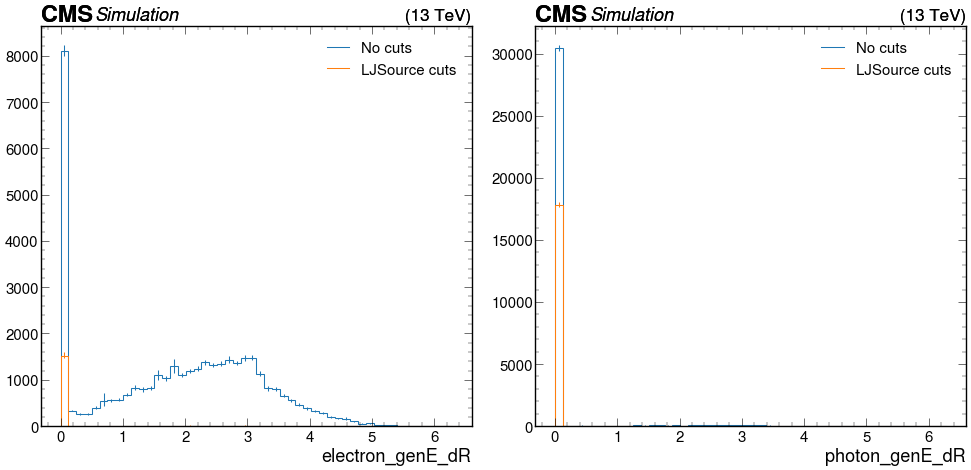

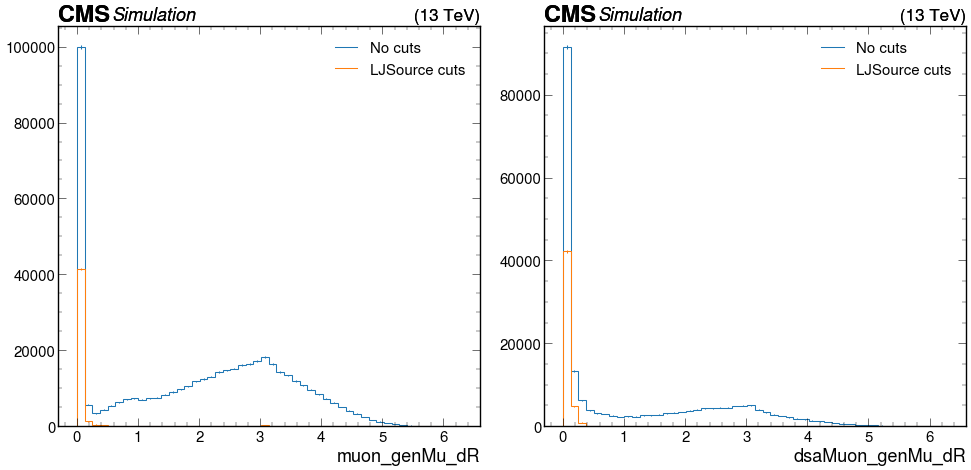

In [4]:
def plot_row(plots, logY=False):
    plt.subplots(1, len(plots), figsize=(10*len(plots), 10))
    for ix, plot in enumerate(plots):
        plt.subplot(1, len(plots), ix+1)
        for ch in channels:
            utilities.plot(hists[plot][ch, :])
        if logY:
            plt.yscale("log")
        plt.legend(legend)
        plt.tight_layout()

plot_row(["electron_genE_dR", "photon_genE_dR"])
plot_row(["muon_genMu_dR", "dsaMuon_genMu_dR"])

ljsource cuts are indeed killing off almost all leptons and photons in the event that aren't near dark photon decays. Oh, I should look at d0 as well, though that's only available for muons and the moment.

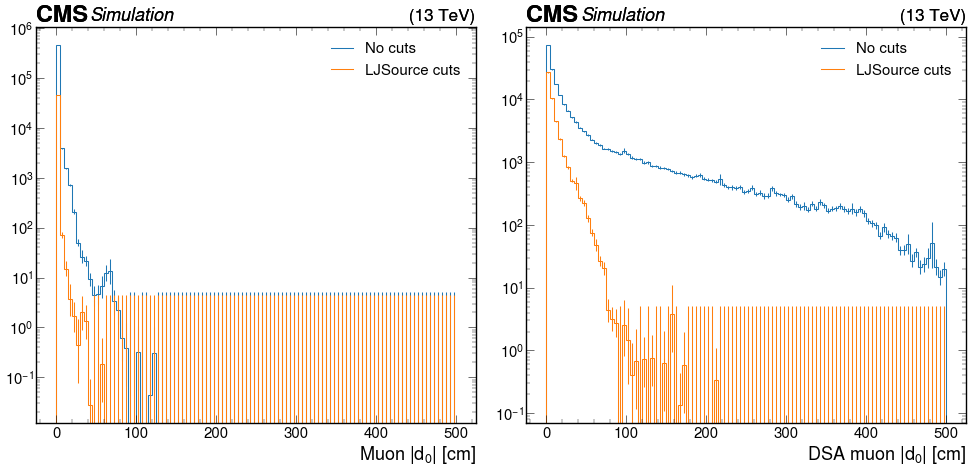

In [5]:
plot_row(["muon_absD0", "dsaMuon_absD0"], logY=True)

Interesting that DSA muon d0 dies off so quickly after applying the ljsource cuts. I'll probably investigate this more thoroughly in the `lepton_displacement` notebook.

Great, I think this suffices for now. No real surprises, and I can always come back and add more plots as necessary.